

# &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;Titanic





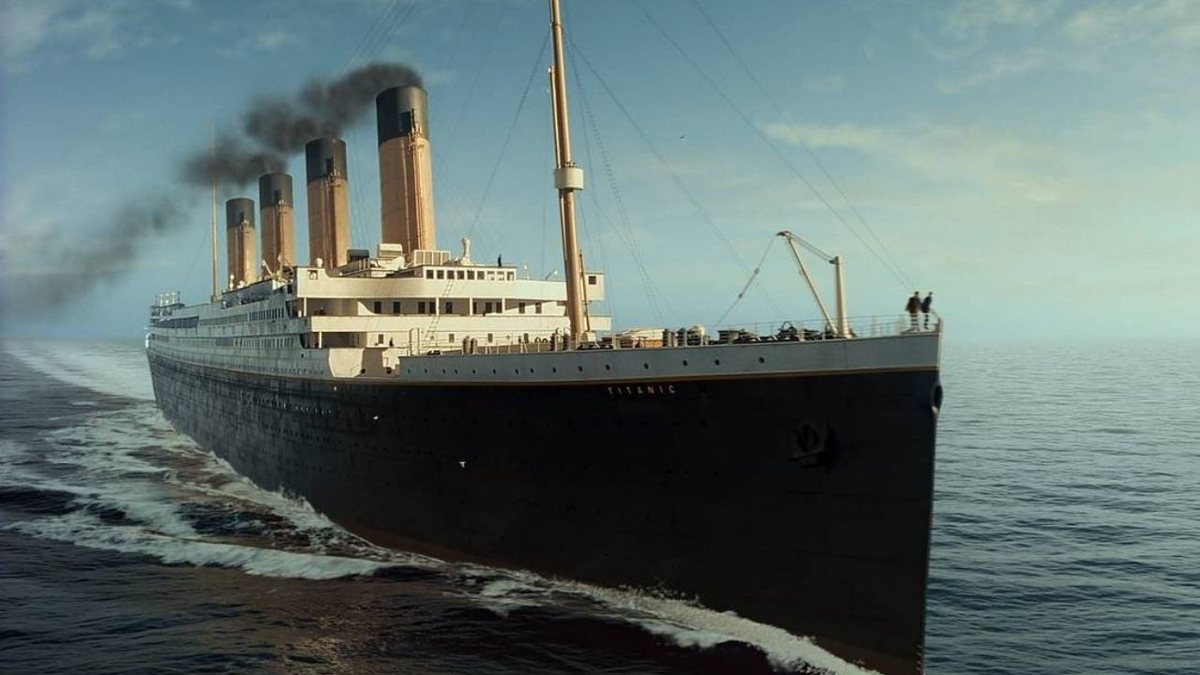

## Introduction

- In this Kaggle competition, we aim to predict which passengers survived the Titanic shipwreck according to economic status (class), sex, age .

- In this competition, we face a binary classification problem and we will try to solve it

- ### These datasets include 11 explanatory variables:

Train data have Survived (dependent variable) and other predictor variables.
Test data include the same variables that in train data, but without Survived (dependent variable) because this data will be submitted to kaggle.

-  #### Data Dictionary

|Feature|Dataset|Description|
|-------|---|---|
|Survival|Train|The number of survived the Titanic shipwreck| 
|Pclass|Train/Test|Economic status (class)| 
|Sex|Train/Test|male or female.| 
|Age|Train/Test|Age in years| 
|Sibsp/Parch|Train/Test|The number of siblings, spouses, or children aboard the Titanic.| 
|ticket|Train/Test|Ticket number.| 
|Fare|Train/Test|Passenger fare| 
|Cabin|Train/Test|Cabin number| 
|Embarked|Train/Test|Port of Embarkation| 



## Importing packages

In [708]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.feature_selection import SelectFromModel
import xgboost as xgb

# To ignore unwanted warnings
import warnings
warnings.filterwarnings('ignore')

## Loading the Titanic

In [709]:
train = pd.read_csv('./datasets/train.csv')
test = pd.read_csv('./datasets/test.csv')
gender_submission = pd.read_csv('./datasets/gender_submission.csv') 

# Exploring the Data

In [710]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [711]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [712]:
train.info()
print('_'*40)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Passenger

## Check Missing Values

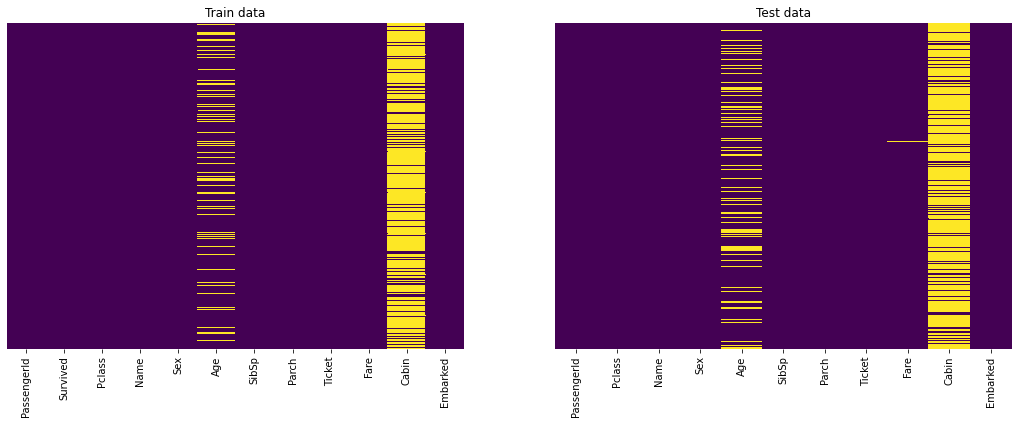

In [713]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18, 6))
# Train data 
sns.heatmap(train.isnull(), yticklabels=False, ax = ax[0], cbar=False, cmap='viridis')
ax[0].set_title('Train data')
# Test data
sns.heatmap(test.isnull(), yticklabels=False, ax = ax[1], cbar=False, cmap='viridis')
ax[1].set_title('Test data');

In [714]:
#missing amount for train set
missing= train.isnull().sum().sort_values(ascending=False)
percentage = (train.isnull().sum()/ train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([missing, percentage], axis=1, keys=['Missing', '%'])
missing_data.head(3)

,Missing,%
Cabin,687,0.771044
Age,177,0.198653
Embarked,2,0.002245


In [715]:
#missing amount for test set
missing= test.isnull().sum().sort_values(ascending=False)
percentage = (test.isnull().sum()/ test.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([missing, percentage], axis=1, keys=['Missing', '%'])
missing_data.head(3)

,Missing,%
Cabin,327,0.782297
Age,86,0.205742
Fare,1,0.002392


# Feature Engineering

 ## Handle Missing Data

### Embarked
From the data description wee see that "Embarked" (Port of Embarkation) contains 3 values: C, Q, S which means: C = Cherbourg, Q = Queenstown, S = Southampton<br>
And since there is only 2 null values in the train, We will fill them with the mode

In [716]:
train['Embarked'].fillna(train['Embarked'].mode()[0], inplace=True)

In [717]:
train['Embarked'].value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

### Fare
There is only one 'Fare' value missing in the test, And we will fill it with the mean grouped by Pclass

In [718]:
isn = pd.isnull(test['Fare'])
test[isn]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


In [719]:
average_of_fare = test.groupby('Pclass')['Fare'].mean()
test['Fare'].fillna(value= average_of_fare[3], inplace=True)

### Age
Both train and test data contains a lot of Age null values, And we will fill them with the mean age with respect to each Pclass, And then we will create age groups

**The mean age by each Pclass.**

In [720]:
# combine train and test then find mean age grouped by Pclass
age_mean_by_pclass = pd.concat([train, test]).groupby('Pclass')['Age'].mean()
age_mean_by_pclass

Pclass
1    39.159930
2    29.506705
3    24.816367
Name: Age, dtype: float64

**We fill them with the mean age with respect to each Pclass.**

In [721]:
train.loc[train['Age'].isnull(), 'Age'] = train['Pclass'].map(age_mean_by_pclass)
test.loc[test['Age'].isnull(), 'Age'] = test['Pclass'].map(age_mean_by_pclass)

#### Age groups

- The graph below shows that the death rate of males was higher than females
- The graph below shows that older passengers had less chance of survival.
<br><br>
Therefore we will create age groups

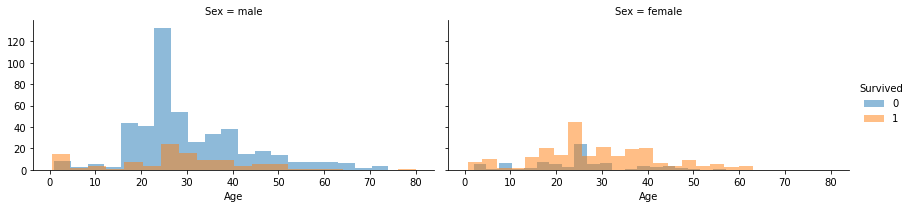

In [722]:
# Sex & Age
g = sns.FacetGrid(train, hue = 'Survived', col = 'Sex', height = 3, aspect = 2)
g.map(plt.hist, 'Age', alpha = .5, bins = 20)
g.add_legend()
plt.show()

In [723]:
train['Age'] = train['Age'].astype(int)
test['Age'] = test['Age'].astype(int)

In [724]:
def age_range(df):
    df['Age'].loc[df['Age'] <= 16 ] = 0
    df['Age'].loc[(df['Age'] > 16) & (df['Age'] <= 32)] = 1
    df['Age'].loc[(df['Age'] > 32) & (df['Age'] <= 48)] = 2
    df['Age'].loc[(df['Age'] > 48) & (df['Age'] <= 64)] = 3
    df['Age'].loc[df['Age'] > 64] = 4   
age_range(train)
age_range(test)

In [725]:
train['Cabin'].isnull().sum()

687

### Cabin

Most of the rows is null, Let's find out if we can gain some benefit

It says, 66% of passengers who have non-missing cabin values survived

In [726]:
train.groupby(train['Cabin'].isnull())['Survived'].mean()

Cabin
False    0.666667
True     0.299854
Name: Survived, dtype: float64

So we can put 0 for null values, and 1 for non null values 

In [727]:
# train
train['Cabin'] = train['Cabin'].notnull().astype('int')
# test
test['Cabin']=test['Cabin'].notnull().astype('int')

## Making several new features 

###  Title Feature

We can extract the title from "Name" feature

In [728]:
train_titles, test_titles = set(), set()  # empty sets to save titles

for train_name, test_name in zip(train['Name'], test['Name']):
    train_titles.add(train_name.split(',')[1].split('.')[0].strip())
    test_titles.add(test_name.split(',')[1].split('.')[0].strip())
print(train_titles,'\n', test_titles)

{'Mme', 'Master', 'Miss', 'Don', 'Mrs', 'Dr', 'Mr', 'Rev'} 
 {'Master', 'Ms', 'Miss', 'Mrs', 'Col', 'Dr', 'Mr', 'Rev', 'Dona'}


And from the above titles we can create a dictionary contains all titles meaning, Then we will create a new feature contains titles

In [729]:
def title(df):
    # all the titles will be replaced to one of the following: 'Mr', 'Ms', Master, 'Officer', 'Royalty', 'Miss'
    df['Title'] = df['Name'].str.split(', ').str[1].str.split('.').str[0]
    
    df['Title'] = df['Title'].replace(['Capt','Col','Major','Dr','Rev'], 'Officer')
    df['Title'] = df['Title'].replace(['Mme','Ms'], 'Mrs')
    df['Title'] = df['Title'].replace(['Jonkheer','Don','Dona','Sir','the Countess','Lady'], 'Royalty')
    df['Title'] = df['Title'].replace('Mlle', 'Miss')

title(train)
title(test)

### Family Size Feature 
(from adding 'SibSp' and  'Parch' togather)

In [730]:
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1
test['FamilySize'] = test['SibSp'] + test['Parch'] + 1

In [731]:
train['FamilySize'].value_counts()

1     537
2     161
3     102
4      29
6      22
5      15
7      12
11      7
8       6
Name: FamilySize, dtype: int64

#### Family size to groups

In [732]:
train['FamilySize'] = train['FamilySize'].astype(int)
test['FamilySize'] = test['FamilySize'].astype(int)
def family_range(df):
    df['FamilySize'].loc[df['FamilySize'] <= 1 ] = 0
    df['FamilySize'].loc[(df['FamilySize'] >= 2) & (df['FamilySize'] <= 4)] = 1
    df['FamilySize'].loc[df['FamilySize'] >= 5] = 2   
family_range(train)
family_range(test)

## Making sure there is no null values

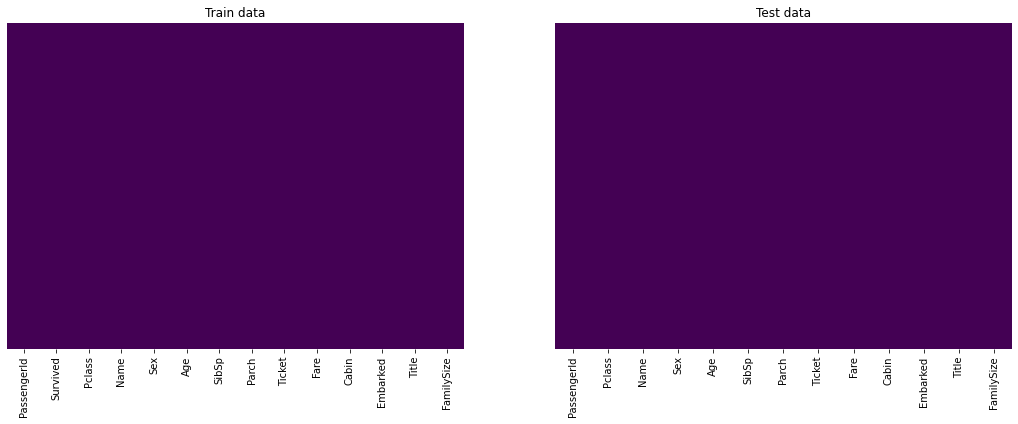

In [733]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18, 6))
# Train data 
sns.heatmap(train.isnull(), yticklabels=False, ax = ax[0], cbar=False, cmap='viridis')
ax[0].set_title('Train data')
# Test data
sns.heatmap(test.isnull(), yticklabels=False, ax = ax[1], cbar=False, cmap='viridis')
ax[1].set_title('Test data');

## One Hot Encoding
Creating Dummies For Categorical Features.

In [734]:
# Train Data
train = pd.get_dummies(train, columns=['Sex','Embarked','Title'],drop_first=True)
# Test Data
test= pd.get_dummies(test, columns=['Sex','Embarked','Title'],drop_first=True)

# Visual Analysis

**Survived Correlation Matrix**

Now let's take a look at the most important variables, which will have strong linear releationship with 
<b>Survived</b> variable .<br><br>

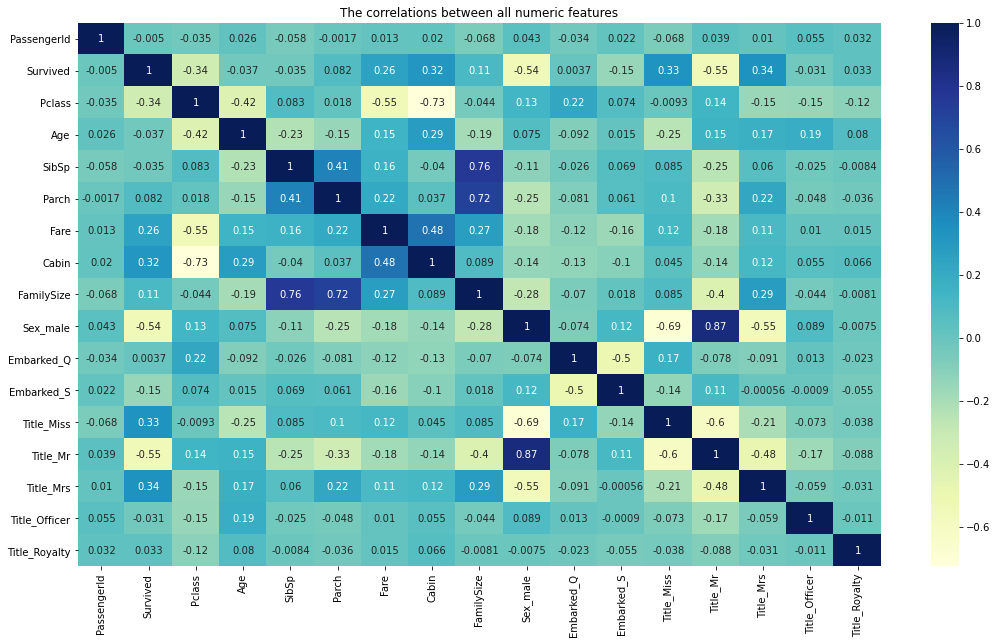

In [735]:
fig=plt.figure(figsize=(18,10))
ax = fig.gca()
sns.heatmap(train.corr(), annot=True,ax=ax, cmap=plt.cm.YlGnBu)
ax.set_title('The correlations between all numeric features')
palette =sns.diverging_palette(80, 110, n=146)
plt.show()

**Correlation with the target**

In [736]:
corr_matrix = train.corr()
corr_matrix["Survived"].sort_values(ascending=False)

Survived         1.000000
Title_Mrs        0.344935
Title_Miss       0.332795
Cabin            0.316912
Fare             0.257307
FamilySize       0.108631
Parch            0.081629
Title_Royalty    0.033391
Embarked_Q       0.003650
PassengerId     -0.005007
Title_Officer   -0.031316
SibSp           -0.035322
Age             -0.037059
Embarked_S      -0.149683
Pclass          -0.338481
Sex_male        -0.543351
Title_Mr        -0.549199
Name: Survived, dtype: float64

**Number of Survivals by Class**

- The graph below shows that the number of survivals in the  3rd class was lower than 1st and 2nd class.

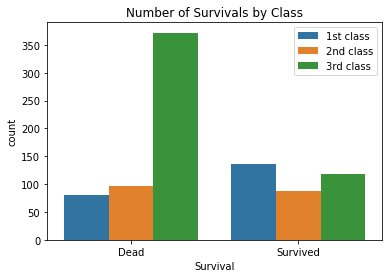

In [737]:
_ = sns.countplot(data=train, x='Survived', hue='Pclass')
_.set_title('Number of Survivals by Class')
_.set_xlabel('Survival')
_.set_xticklabels(['Dead', 'Survived'])
_.legend(['1st class', '2nd class', '3rd class']);

In [738]:
print('Survival rate per class: ')
train.groupby('Pclass')['Survived'].sum() / train['Pclass'].value_counts() # Survive percent by class

Survival rate per class: 


1    0.629630
2    0.472826
3    0.242363
dtype: float64

**Number of Males and Females by Class**

- The graph below shows that most of men were in the 3rd class.  

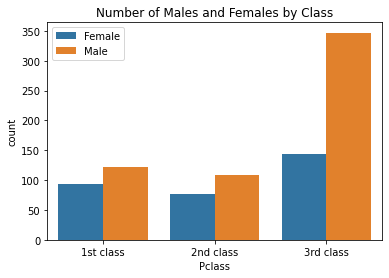

In [739]:
_ = sns.countplot(data=train, x='Pclass', hue='Sex_male')
_.set_title('Number of Males and Females by Class')
_.set_xticklabels(['1st class', '2nd class', '3rd class'])
_.legend(['Female', 'Male']);

**Number of Deaths by Family Size**

- The graph below shows the number of deaths for people by there Family Size

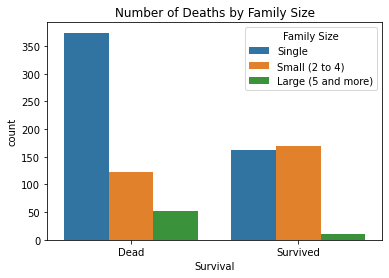

In [740]:
_ = sns.countplot(data=train, x='Survived', hue='FamilySize')
_.set_title('Number of Deaths by Family Size')
_.set_xlabel('Survival')
_.set_xticklabels(['Dead','Survived'])
_.legend(['Single', 'Small (2 to 4)', 'Large (5 and more)'], title='Family Size');

In [741]:
print('Survival rate for people by there Family Size: ')
(train.groupby('FamilySize')['Survived'].sum() / train['FamilySize'].value_counts()).rename({0:'Single', 1:'Small', 2:'Large'})

Survival rate for people by there Family Size: 


FamilySize
Single    0.303538
Small     0.578767
Large     0.161290
dtype: float64

**Number of Survivals and Deaths Per Gender**

- The graph below shows that the number of deaths in males was a lot more than females

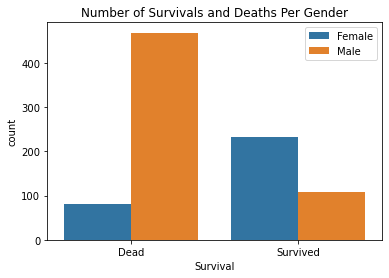

In [742]:
_ = sns.countplot(data=train, x='Survived', hue='Sex_male')
_.set_title('Number of Survivals and Deaths Per Gender')
_.set_xlabel('Survival')
_.set_xticklabels(['Dead','Survived'])
_.legend(['Female', 'Male']);

In [743]:
print('Survival rate per gender: ')
(train.groupby('Sex_male')['Survived'].sum() / train['Sex_male'].value_counts()).rename(index={0:'female',1:'male'})

Survival rate per gender: 


female    0.742038
male      0.188908
dtype: float64

# Dealing with imbalanced data

We can see below that the data is imbalanced, And we will try different techniques to solve this problem

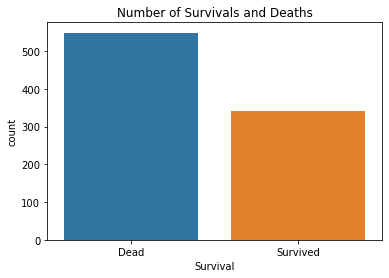

In [744]:
_ = sns.countplot(data=train, x='Survived')
_.set_title('Number of Survivals and Deaths')
_.set_xlabel('Survival')
_.set_xticklabels(['Dead','Survived']);

In [745]:
train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

## Oversampling (worse results)
Trying to balance the data by duplicating some rows for people who survived to be 549 survived and 549 dead

In [746]:
# majority_count, minority_count = train['Survived'].value_counts()
# majority = train[train['Survived'] == 0]
# minority = train[train['Survived'] == 1]

# minority_overSamp = minority.sample(majority_count, replace=True, random_state=55)
# train_overSamp = pd.concat([majority, minority_overSamp])

# train_overSamp['Survived'].value_counts()

## Undersampling (worse results)
Trying to balance the data by removing some rows for people who are dead to be 342 survived and 342 dead

In [653]:
# majority_count, minority_count = train['Survived'].value_counts()
# majority = train[train['Survived'] == 0]
# minority = train[train['Survived'] == 1]

# majority_underSamp = majority.sample(minority_count)
# train_underSamp = pd.concat([majority_underSamp, minority], axis=0)

# train_underSamp['Survived'].value_counts()

## Smote sampling (worse results)

In [654]:
# from imblearn.over_sampling import SMOTE
# oversample = SMOTE()
# X, y = oversample.fit_resample(X, y)

# Modeling 

## Features Selection

In [655]:
# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import chi2
# ksel = SelectKBest(chi2, k=9) 
# ksel.fit(X, y) 
# new_X = ksel.transform(X)
# new_testing = ksel.transform(testing)

# ix = ksel.get_support()
# pd.DataFrame(new_X, columns = X.columns[ix]).head(5)

### Dropping Some Features

In [656]:
# Train data
features_drop = ['PassengerId','Name', 'Ticket', 'Survived','SibSp','Parch']

In [657]:
selected_features = [x for x in train.columns if x not in features_drop]

In [658]:
# Test data
features_drop_test = ['PassengerId','Name', 'Ticket','SibSp','Parch']

In [659]:
selected_features_test = [x for x in test.columns if x not in features_drop_test]

In [660]:
# Train data
X = train[selected_features]
y = train['Survived']

In [661]:
# Test data
testing = test[selected_features_test]

**Splitting and Standardizing Train Data to Obtain Test Scores**

In [662]:
ss = StandardScaler()
Xs = ss.fit_transform(X)

In [663]:
testing_s = ss.transform(testing)

In [664]:
X_train, X_test, y_train, y_test = train_test_split(
    Xs, y, test_size = .3, random_state= 42, stratify = y) 

## Apply modeling

In [665]:
def modeling(model, X_train, y_train, test_data, X_test=None, y_test=None, prefit=False):
    '''Takes model and data then print model results with some metrics then return predictions'''
    
    start = "\033[1m" # to create BOLD print
    end = "\033[0;0m" # to create BOLD print
    
    # Print bold model name 
    model_name = str(model)#.split('(')[0]
    print(''.join(['\n', start, model_name, end]))
    
    #Fit model
    if not prefit:
        model.fit(X_train, y_train)
    
    #Accuarcy score    
    print('Train Score', model.score(X_train, y_train))
    try:
        print('Test Score :', model.score(X_test, y_test))
    
        #confusion matrix
        X_test_pred = model.predict(X_test)
        print('\nconfusion matrix\n', confusion_matrix(y_test, X_test_pred))  
    except: pass
    
    #cross val score
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_res = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    print('\nCV scores: ', cv_res)
    print('CV scores mean: ', cv_res.mean())  
    
    #predictions
    y_pred = model.predict(test_data)
    print('\nFirst 10 Predictions: \n', y_pred[:10])


    return y_pred

In [666]:
# Models
logreg = LogisticRegression(max_iter=300)
knn = KNeighborsClassifier(n_neighbors=7)  
svm_lin = svm.SVC(kernel='linear', C=33)
svm_poly = svm.SVC(kernel='poly', C=3)
svm_rbf = svm.SVC(kernel='rbf', C=33)

# randomF = RandomForestClassifier(max_depth=350, n_estimators=9, max_features=11, random_state=14, min_samples_split=3)
randomF = RandomForestClassifier(max_depth=350, random_state=42)
dtree= DecisionTreeClassifier(random_state=42)
extree = ExtraTreesClassifier(n_estimators=66, min_samples_split=7, random_state=42)
xgb_model = xgb.XGBClassifier(colsample_bytree= 0.8, gamma= 1, learning_rate= 0.002,
                              max_depth= 8, min_child_weight= 1,subsample= 0.8,)



models = [(logreg,'logreg'), (knn,'knn'), (svm_lin,'svm_lin'), (svm_poly,'svm_poly'), (svm_rbf,'svm_rbf'),
          (randomF,'randomF'), (dtree,'dtree'), (extree,'extree'), (xgb_model,'xgb_model')]

preds = {}    # empty dict to save all models predictions
for model, name in models:
    preds[name] = modeling(model, X_train, y_train, testing_s, X_test, y_test)


LogisticRegression(max_iter=300)
Train Score 0.8475120385232745
Test Score : 0.8283582089552238

confusion matrix
 [[144  21]
 [ 25  78]]

CV scores:  [0.776      0.808      0.84       0.87903226 0.83064516]
CV scores mean:  0.8267354838709677

First 10 Predictions: 
 [0 0 0 0 1 0 1 0 1 0]

KNeighborsClassifier(n_neighbors=7)
Train Score 0.8571428571428571
Test Score : 0.8246268656716418

confusion matrix
 [[137  28]
 [ 19  84]]

CV scores:  [0.784      0.824      0.824      0.83064516 0.7983871 ]
CV scores mean:  0.8122064516129033

First 10 Predictions: 
 [0 1 0 0 0 0 1 0 1 0]

SVC(C=33, kernel='linear')
Train Score 0.8346709470304976
Test Score : 0.8283582089552238

confusion matrix
 [[146  19]
 [ 27  76]]

CV scores:  [0.776      0.832      0.832      0.87903226 0.75806452]
CV scores mean:  0.8154193548387096

First 10 Predictions: 
 [0 1 0 0 1 0 1 0 1 0]

SVC(C=3, kernel='poly')
Train Score 0.8619582664526485
Test Score : 0.8059701492537313

confusion matrix
 [[144  21]
 [ 31  72

In [673]:
def g_search(model, param, X_train, y_train, test_data, X_test=None, y_test=None):
    '''Simple grid search with kfold'''
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    gs = GridSearchCV(model,
                  param,
                  scoring='accuracy',
                  cv=cv,
                  n_jobs=-1,
                  verbose=1)
    gs.fit(X_train, y_train)
    
    # Results
    y_pred = modeling(gs.best_estimator_, X_train, y_train, test_data, X_test, y_test, prefit=True) # print results and return predictions
    
    print('Best parameters: ', gs.best_params_)
    
    return y_pred

In [668]:
# grid search using all the data (Xs, y)
grid_logreg_pred = g_search(LogisticRegression(), {'C': np.arange(1, 40, 1)}, Xs, y, testing_s)
grid_knn_pred = g_search(KNeighborsClassifier(), {'n_neighbors': np.arange(1, 100, 1)}, Xs, y, testing_s)
grid_svm_lin_pred = g_search(svm.SVC(kernel='linear'), {'C': np.arange(1, 40, 1)}, Xs, y, testing_s)
grid_svm_poly_pred = g_search(svm.SVC(kernel='poly'), {'C': np.arange(1, 40, 1)}, Xs, y, testing_s)
grid_svm_rbf_pred = g_search(svm.SVC(kernel='rbf'), {'C': np.arange(1, 40, 1)}, Xs, y, testing_s)


LogisticRegression(C=1)
Train Score 0.8316498316498316

CV scores:  [0.83798883 0.8258427  0.81460674 0.84269663 0.85393258]
CV scores mean:  0.8350134957002071

First 10 Predictions: 
 [0 1 0 0 1 0 1 0 1 0]
Best parameters:  {'C': 1}

KNeighborsClassifier(n_neighbors=12)
Train Score 0.8496071829405163

CV scores:  [0.83240223 0.83146067 0.83707865 0.8258427  0.83707865]
CV scores mean:  0.832772581758835

First 10 Predictions: 
 [0 1 0 0 1 0 1 0 1 0]
Best parameters:  {'n_neighbors': 12}

SVC(C=2, kernel='linear')
Train Score 0.8338945005611672

CV scores:  [0.83798883 0.82022472 0.81460674 0.83146067 0.84269663]
CV scores mean:  0.8293955181721172

First 10 Predictions: 
 [0 1 0 0 1 0 1 0 1 0]
Best parameters:  {'C': 2}

SVC(C=3, kernel='poly')
Train Score 0.8585858585858586

CV scores:  [0.82681564 0.83146067 0.8258427  0.84831461 0.80898876]
CV scores mean:  0.8282844768062269

First 10 Predictions: 
 [0 1 0 0 1 0 1 0 1 0]
Best parameters:  {'C': 3}

SVC(C=4)
Train Score 0.8585858

**BaggingClassifier with a decision tree base estimator**

In [312]:
dt = DecisionTreeClassifier()
dt_en = BaggingClassifier(base_estimator=dt, n_estimators=500, max_features=4, random_state=55)

dt_en_pred = modeling(dt_en, Xs, y, testing_s) 


BaggingClassifier(base_estimator=DecisionTreeClassifier(), max_features=4,
                  n_estimators=500, random_state=55)
Train Score 0.9012345679012346

CV scores:  [0.83798883 0.84831461 0.82022472 0.83707865 0.85393258]
CV scores mean:  0.8395078777226791

First 10 Predictions: 
 [0 1 0 0 1 0 0 0 1 0]


**AdaBoost Classifier**

In [313]:
adaboost = AdaBoostClassifier(n_estimators=67)
adaboost.fit(X_train, y_train)

adaboost_pred = modeling(adaboost, Xs, y, testing_s) 


AdaBoostClassifier(n_estimators=67)
Train Score 0.8395061728395061

CV scores:  [0.81564246 0.8258427  0.80898876 0.82022472 0.8258427 ]
CV scores mean:  0.8193082669010107

First 10 Predictions: 
 [0 1 0 0 1 0 1 0 1 0]


## XGBoost (best result)

In [674]:
xgb_model = xgb.XGBClassifier(

    colsample_bytree= 0.8,
    gamma= 1,
    learning_rate= 0.002,
    max_depth= 8,
    min_child_weight= 1,
    subsample= 0.8,
)

xgb_pred = modeling(xgb_model, Xs, y, testing_s)


XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.8, gamma=1, gpu_id=None,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.002, max_delta_step=None, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=0.8, tree_method=None,
              validate_parameters=None, verbosity=None)
Train Score 0.8709315375982043

CV scores:  [0.8547486  0.85393258 0.83707865 0.83707865 0.8258427 ]
CV scores mean:  0.8417362375243236

First 10 Predictions: 
 [0 1 0 0 1 0 1 0 1 0]


**Grid Search XGBOOST**

In [681]:
param_grid = {
                   'n_estimators': np.arange(50,500,20),
                   'max_depth' : [i for i in range(1,15,1)],
                   'gamma': [1,2,3,4],
                   'reg_alpha': [0,1,2,3]
}
xgb_model = xgb.XGBClassifier(

    colsample_bytree= 0.8,
    learning_rate= 0.001,
    min_child_weight= 1,
    subsample= 0.8,
)

grid_xgb_pred = g_search(xgb_model, param_grid, Xs, y, testing_s)

Fitting 5 folds for each of 5152 candidates, totalling 25760 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 440 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 690 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:   35.4s
[Parallel(n_jobs=-1)]: Done 1490 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2040 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2690 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 3440 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 4290 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 5240 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 6290 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 7440 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 8690 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 10040 tasks      | elapsed: 12.8min
[Parallel(n_jobs=-1)]: Done 11490 tasks     


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.001, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)
Train Score 0.8653198653198653

CV scores:  [0.8547486  0.85955056 0.84269663 0.84269663 0.84269663]
CV scores mean:  0.8484778105580315

First 10 Predictions: 
 [0 1 0 0 1 0 1 0 1 0]
Best parameters:  {'gamma': 1, 'max_depth': 6, 'n_estimators': 50, 'reg_alpha': 0}


### Submission

In [706]:
thesubmission = gender_submission.copy()
thesubmission['Survived'] = xgb_pred
thesubmission['Survived'].head(10)

0    0
1    1
2    0
3    0
4    1
5    0
6    1
7    0
8    1
9    0
Name: Survived, dtype: int64

In [707]:
thesubmission.to_csv('thesubmission.csv', index=False)

### Best model parameters

In [ ]:
# xgb_model = xgb.XGBClassifier(

#     colsample_bytree= 0.8,
#     gamma= 1,
#     learning_rate= 0.002,
#     max_depth= 8,
#     min_child_weight= 1,
#     subsample= 0.8     
# )

# Train Score 0.8709315375982043

# CV scores:  [0.8547486  0.85393258 0.83707865 0.83707865 0.8258427 ]
# CV scores mean:  0.8417362375243236

# First 10 Predictions: 
#  [0 1 0 0 1 0 1 0 1 0]

# features_drop = ['PassengerId','Name', 'Ticket', 'Survived','SibSp','Parch']

# X_train, X_test, y_train, y_test = train_test_split(
#     Xs, y, test_size=.3,random_state=55, stratify=y) 

# Kaggle score: 0.79186

### Kaggle Score
(This is an old score because Titanic validation data on kaggle change every month)
<br>Old score: 0.80382
<br>Current: 0.79186

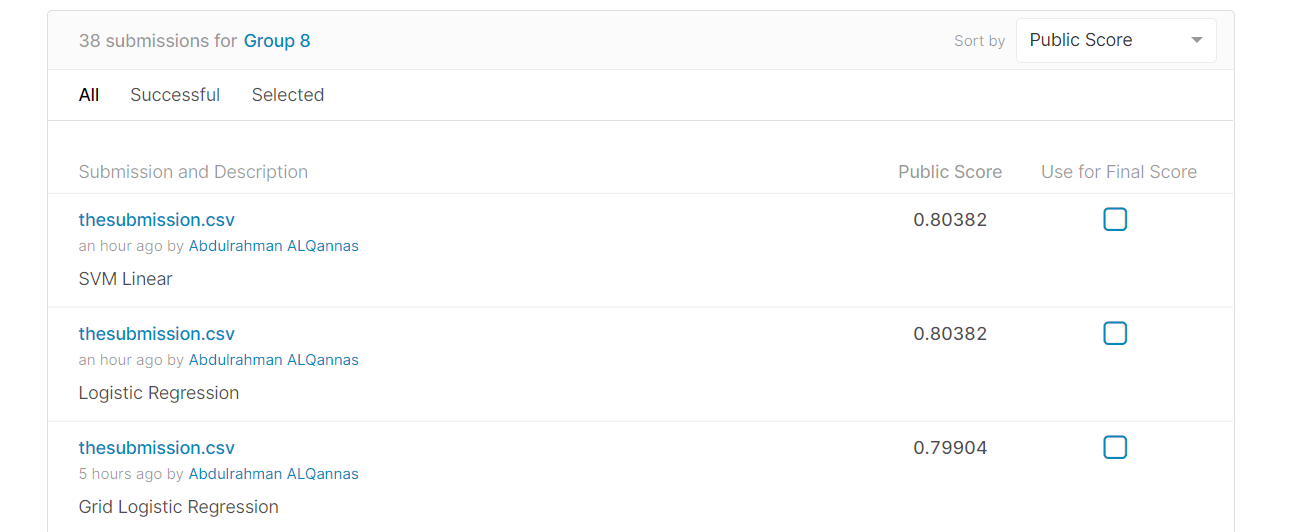